# RL Traveling S

In this notebook, we implement a reinforcement learning approach to the traveling salesman problem. It is based on Q-learning and structure2vec graph embeddings.

In [1]:
import numpy as np
import torch
import random
import math
from collections import namedtuple
import os
import time

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.signal import medfilt

""" Note: the code is not optimized for GPU
"""
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

## Create Graph Instances
Below we implement a small method to generate random graph instances.

In [2]:
def get_graph_mat(n=20, size=1):
    """ Throws n nodes uniformly at random on a square, and build a (fully connected) graph.
        Returns the (N, 2) coordinates matrix, and the (N, N) matrix containing pairwise euclidean distances.
    """
    coords = size * np.random.uniform(size=(n,2))
    dist_mat = distance_matrix(coords, coords)
    return coords, dist_mat

def plot_graph(coords, mat):
    """ Utility function to plot the fully connected graph
    """
    n = len(coords)
    
    plt.scatter(coords[:,0], coords[:,1], s=[50 for _ in range(n)])
    for i in range(n):
        for j in range(n):
            if j < i:
                plt.plot([coords[i,0], coords[j,0]], [coords[i,1], coords[j,1]], 'b', alpha=0.7)

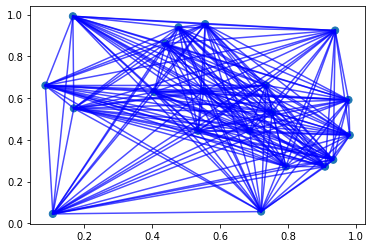

In [3]:
coords, W_np = get_graph_mat(n=20)
plot_graph(coords, W_np)

## Define the state
We now define the state tuple, containing a graph (given by a weights matrix `W`), the noode coordinates `coords` and the partial solution (list of visited nodes).
We also define the function `state2tens`, which translates such tuples into tensors (partially loosing the sequence order information).

In [5]:
State = namedtuple('State', ('W', 'coords', 'partial_solution'))
  
def state2tens(state):
    """ Creates a Pytorch tensor representing the history of visited nodes, from a (single) state tuple.
        
        Returns a (Nx5) tensor, where for each node we store whether this node is in the sequence,
        whether it is first or last, and its (x,y) coordinates.
    """
    solution = set(state.partial_solution)
    sol_last_node = state.partial_solution[-1] if len(state.partial_solution) > 0 else -1
    sol_first_node = state.partial_solution[0] if len(state.partial_solution) > 0 else -1
    coords = state.coords
    nr_nodes = coords.shape[0]

    xv = [[(1 if i in solution else 0),
           (1 if i == sol_first_node else 0),
           (1 if i == sol_last_node else 0),
           coords[i,0],
           coords[i,1]
          ] for i in range(nr_nodes)]
    
    return torch.tensor(xv, dtype=torch.float32, requires_grad=False, device=device)

## The Q-Function
Below, we write the neural network that will parameterize the function Q(s, a).

In [6]:
class QNet(nn.Module):
    """ The neural net that will parameterize the function Q(s, a)
    
        The input is the state (containing the graph and visited nodes),
        and the output is a vector of size N containing Q(s, a) for each of the N actions a.
    """    
    
    def __init__(self, emb_dim, T=4):
        """ emb_dim: embedding dimension p
            T: number of iterations for the graph embedding
        """
        super(QNet, self).__init__()
        self.emb_dim = emb_dim
        self.T = T
        
        # We use 5 dimensions for representing the nodes' states:
        # * A binary variable indicating whether the node has been visited
        # * A binary variable indicating whether the node is the first of the visited sequence
        # * A binary variable indicating whether the node is the last of the visited sequence
        # * The (x, y) coordinates of the node.
        self.node_dim = 5
        
        # We can have an extra layer after theta_1 (for the sake of example to make the network deeper)
        nr_extra_layers_1 = 1
        
        # Build the learnable affine maps:
        self.theta1 = nn.Linear(self.node_dim, self.emb_dim, True)
        self.theta2 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta3 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta4 = nn.Linear(1, self.emb_dim, True)
        self.theta5 = nn.Linear(2*self.emb_dim, 1, True)
        self.theta6 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta7 = nn.Linear(self.emb_dim, self.emb_dim, True)
        
        self.theta1_extras = [nn.Linear(self.emb_dim, self.emb_dim, True) for _ in range(nr_extra_layers_1)]
        
    def forward(self, xv, Ws):
        # xv: The node features (batch_size, num_nodes, node_dim)
        # Ws: The graphs (batch_size, num_nodes, num_nodes)
        
        num_nodes = xv.shape[1]
        batch_size = xv.shape[0]
        
        # pre-compute 1-0 connection matrices masks (batch_size, num_nodes, num_nodes)
        conn_matrices = torch.where(Ws > 0, torch.ones_like(Ws), torch.zeros_like(Ws)).to(device)
        
        # Graph embedding
        # Note: we first compute s1 and s3 once, as they are not dependent on mu
        mu = torch.zeros(batch_size, num_nodes, self.emb_dim, device=device)
        s1 = self.theta1(xv)  # (batch_size, num_nodes, emb_dim)
        for layer in self.theta1_extras:
            s1 = layer(F.relu(s1))  # we apply the extra layer
        
        s3_1 = F.relu(self.theta4(Ws.unsqueeze(3)))  # (batch_size, nr_nodes, nr_nodes, emb_dim) - each "weigth" is a p-dim vector        
        s3_2 = torch.sum(s3_1, dim=1)  # (batch_size, nr_nodes, emb_dim) - the embedding for each node
        s3 = self.theta3(s3_2)  # (batch_size, nr_nodes, emb_dim)
        
        for t in range(self.T):
            s2 = self.theta2(conn_matrices.matmul(mu))    
            mu = F.relu(s1 + s2 + s3)
            
        """ prediction
        """
        # we repeat the global state (summed over nodes) for each node, 
        # in order to concatenate it to local states later
        global_state = self.theta6(torch.sum(mu, dim=1, keepdim=True).repeat(1, num_nodes, 1))
        
        local_action = self.theta7(mu)  # (batch_dim, nr_nodes, emb_dim)
            
        out = F.relu(torch.cat([global_state, local_action], dim=2))
        return self.theta5(out).squeeze(dim=2)

In [7]:
""" See what the model returns
"""
model = QNet(3, T=1).to(device)
coords, W_np = get_graph_mat(n=10)
W = torch.tensor(W_np, dtype=torch.float32, device=device)
xv = torch.rand((1, W.shape[0], 5)).to(device) # random node state
Ws = W.unsqueeze(0)

y = model(xv, Ws)
print('model output: {}'.format(y))

model output: tensor([[-0.2141, -0.2141, -0.2141, -0.2141, -0.2141, -0.2141, -0.2141, -0.2141,
         -0.2141, -0.2141]], grad_fn=<SqueezeBackward1>)


### A wrapper around the neural net
Below, we define the class `QFunction`, which will act as a wrapper around the neural net `QNet`, and can manipulate TSP (partial) solutions and translate them to tensors.

In [8]:
class QFunction():
    def __init__(self, model, optimizer, lr_scheduler):
        self.model = model  # The actual QNet
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_fn = nn.MSELoss()
    
    def predict(self, state_tsr, W):
        # batch of 1 - only called at inference time
        with torch.no_grad():
            estimated_rewards = self.model(state_tsr.unsqueeze(0), W.unsqueeze(0))
        return estimated_rewards[0]
                
    def get_best_action(self, state_tsr, state):
        """ Computes the best (greedy) action to take from a given state
            Returns a tuple containing the ID of the next node and the corresponding estimated reward
        """
        W = state.W
        estimated_rewards = self.predict(state_tsr, W)  # size (nr_nodes,)
        sorted_reward_idx = estimated_rewards.argsort(descending=True)
        
        solution = state.partial_solution
        
        already_in = set(solution)
        for idx in sorted_reward_idx.tolist():
            if (len(solution) == 0 or W[solution[-1], idx] > 0) and idx not in already_in:
                return idx, estimated_rewards[idx].item()
        
    def batch_update(self, states_tsrs, Ws, actions, targets):
        """ Take a gradient step using the loss computed on a batch of (states, Ws, actions, targets)
        
            states_tsrs: list of (single) state tensors
            Ws: list of W tensors
            actions: list of actions taken
            targets: list of targets (resulting estimated rewards after taking the actions)
        """        
        Ws_tsr = torch.stack(Ws).to(device)
        xv = torch.stack(states_tsrs).to(device)
        self.optimizer.zero_grad()
        
        # the rewards estimated by Q for the given actions
        estimated_rewards = self.model(xv, Ws_tsr)[range(len(actions)), actions]
        
        loss = self.loss_fn(estimated_rewards, torch.tensor(targets, device=device))
        loss_val = loss.item()
        
        loss.backward()
        self.optimizer.step()        
        self.lr_scheduler.step()
        
        return loss_val

## Define experiences & memory
We'll now a tuple representing an experience, and the memory that contains such experiences.
An experience is composed of a (state, action) tuple, and the corresponding "next state" and reward. The "next state" can be N step after the "state" in the case of N-step Q-learning. In experiences, we save states both in their tuple and tensor representations, in order to avoid computing these somewhat expensive translations after the experience has been stored.

The `Memory` class implements a memory of limited size.

In [9]:
# Note: we store state tensors in experience to compute these tensors only once later on
Experience = namedtuple('Experience', ('state', 'state_tsr', 'action', 'reward', 'next_state', 'next_state_tsr'))

class Memory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.nr_inserts = 0
        
    def remember(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience
        self.position = (self.position + 1) % self.capacity
        self.nr_inserts += 1
        
    def sample_batch(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return min(self.nr_inserts, self.capacity)

## Other useful things
Below, we'll write a few more helper functions for computing solution length, deciding if a state is final and getting a next node at random from the graph.

In [19]:
def total_distance(solution, W):
    if len(solution) < 2:
        return 0  # there is no travel
    
    total_dist = 0
    for i in range(len(solution) - 1):
        total_dist += W[solution[i], solution[i+1]].item()
        
    # if this solution is "complete", go back to initial point
    if len(solution) == W.shape[0]:
        total_dist += W[solution[-1], solution[0]].item()
        total_dist = total_dist*1/2

    return total_dist
        
def is_state_final(state):
    return len(set(state.partial_solution)) == state.W.shape[0]

def get_next_neighbor_random(state):
    solution, W = state.partial_solution, state.W
    
    if len(solution) == 0:
        return random.choice(range(W.shape[0]))
    already_in = set(solution)
    candidates = list(filter(lambda n: n.item() not in already_in, W[solution[-1]].nonzero()))
    if len(candidates) == 0:
        return None
    return random.choice(candidates).item()

## Training Code
### Hyper-parameters

In [11]:
SEED = 1  # A seed for the random number generator

# Graph
NR_NODES = 20  # Number of nodes N
EMBEDDING_DIMENSIONS = 5  # Embedding dimension D
EMBEDDING_ITERATIONS_T = 1  # Number of embedding iterations T

# Learning
NR_EPISODES = 4001
MEMORY_CAPACITY = 10000
N_STEP_QL = 2  # Number of steps (n) in n-step Q-learning to wait before computing target reward estimate
BATCH_SIZE = 16

GAMMA = 0.9
INIT_LR = 5e-3
LR_DECAY_RATE = 1. - 2e-5  # learning rate decay

MIN_EPSILON = 0.1
EPSILON_DECAY_RATE = 6e-4  # epsilon decay

FOLDER_NAME = './models'  # where to checkpoint the best models

### Model Initialization & checkpointing
We will save our best models over the course of training - here we just define two functions for loading and checkpointing models

In [12]:
def init_model(fname=None):
    """ Create a new model. If fname is defined, load the model from the specified file.
    """
    Q_net = QNet(EMBEDDING_DIMENSIONS, T=EMBEDDING_ITERATIONS_T).to(device)
    optimizer = optim.Adam(Q_net.parameters(), lr=INIT_LR)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY_RATE)
    
    if fname is not None:
        checkpoint = torch.load(fname)
        Q_net.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    
    Q_func = QFunction(Q_net, optimizer, lr_scheduler)
    return Q_func, Q_net, optimizer, lr_scheduler

def checkpoint_model(model, optimizer, lr_scheduler, loss, 
                     episode, avg_length):
    if not os.path.exists(FOLDER_NAME):
        os.makedirs(FOLDER_NAME)
    
    fname = os.path.join(FOLDER_NAME, 'ep_{}'.format(episode))
    fname += '_length_{}'.format(avg_length)
    fname += '.pt'
    
    torch.save({
        'episode': episode,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'loss': loss,
        'avg_length': avg_length
    }, fname)

### Training Loop
The code below is slightly more complex than the version appearing in the blog article. Notably, here in several places we maintain states represented both as tuples and tensors. We cache the tensor versions in order to avoid re-computing them many times. Also different from the article, the version below implements a version of n-step Q-learning, it checkpoints the best models (according to the median path length), and prints some information.

In [13]:
# seed everything for reproducible results first:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Create module, optimizer, LR scheduler, and Q-function
Q_func, Q_net, optimizer, lr_scheduler = init_model()

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)
losses = []
path_lengths = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

for episode in range(NR_EPISODES):
    # sample a new random graph
    coords, W_np = get_graph_mat(n=NR_NODES)
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)
    
    # current partial solution - a list of node index
    solution = [random.randint(0, NR_NODES-1)]
    
    # current state (tuple and tensor)
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)
    
    # Keep track of some variables for insertion in replay memory:
    states = [current_state]
    states_tsrs = [current_state_tsr]  # we also keep the state tensors here (for efficiency)
    rewards = []
    actions = []
    
    # current value of epsilon
    epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)
    
    nr_explores = 0
    t = -1
    while not is_state_final(current_state):
        t += 1  # time step of this episode
        
        if epsilon >= random.random():
            # explore
            next_node = get_next_neighbor_random(current_state)
            nr_explores += 1
        else:
            # exploit
            next_node, est_reward = Q_func.get_best_action(current_state_tsr, current_state)
            if episode % 50 == 0:
                print('Ep {} | current sol: {} / next est reward: {}'.format(episode, solution, est_reward))
        
        next_solution = solution + [next_node]
        
        # reward observed for taking this step        
        reward = -(total_distance(next_solution, W) - total_distance(solution, W))
        
        next_state = State(partial_solution=next_solution, W=W, coords=coords)
        next_state_tsr = state2tens(next_state)
        
        # store rewards and states obtained along this episode:
        states.append(next_state)
        states_tsrs.append(next_state_tsr)
        rewards.append(reward)
        actions.append(next_node)
        
        # store our experience in memory, using n-step Q-learning:
        if len(solution) >= N_STEP_QL:
            memory.remember(Experience(state=states[-N_STEP_QL],
                                       state_tsr=states_tsrs[-N_STEP_QL],
                                       action=actions[-N_STEP_QL],
                                       reward=sum(rewards[-N_STEP_QL:]),
                                       next_state=next_state,
                                       next_state_tsr=next_state_tsr))
            
        if is_state_final(next_state):
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(state=states[-n],
                                           state_tsr=states_tsrs[-n], 
                                           action=actions[-n], 
                                           reward=sum(rewards[-n:]), 
                                           next_state=next_state,
                                           next_state_tsr=next_state_tsr))
        
        # update state and current solution
        current_state = next_state
        current_state_tsr = next_state_tsr
        solution = next_solution
        
        # take a gradient step
        loss = None
        if len(memory) >= BATCH_SIZE and len(memory) >= 2000:
            experiences = memory.sample_batch(BATCH_SIZE)
            
            batch_states_tsrs = [e.state_tsr for e in experiences]
            batch_Ws = [e.state.W for e in experiences]
            batch_actions = [e.action for e in experiences]
            batch_targets = []
            
            for i, experience in enumerate(experiences):
                target = experience.reward
                if not is_state_final(experience.next_state):
                    _, best_reward = Q_func.get_best_action(experience.next_state_tsr, 
                                                            experience.next_state)
                    target += GAMMA * best_reward
                batch_targets.append(target)
                
            # print('batch targets: {}'.format(batch_targets))
            loss = Q_func.batch_update(batch_states_tsrs, batch_Ws, batch_actions, batch_targets)
            losses.append(loss)
            
            """ Save model when we reach a new low average path length
            """
            med_length = np.median(path_lengths[-100:])
            if med_length < current_min_med_length:
                current_min_med_length = med_length
                checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length)
                
    length = total_distance(solution, W)
    path_lengths.append(length)

    if episode % 10 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f / lr = %.4f' % (
            episode, (-1 if loss is None else loss), np.median(path_lengths[-50:]), length, epsilon,
            Q_func.optimizer.param_groups[0]['lr']))
        found_solutions[episode] = (W.clone(), coords.copy(), [n for n in solution])

Ep 0. Loss = -1.000 / median length = 10.468 / last = 10.4677 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = -1.000 / median length = 10.503 / last = 11.5012 / epsilon = 0.9940 / lr = 0.0050
Ep 20. Loss = -1.000 / median length = 10.468 / last = 9.9951 / epsilon = 0.9881 / lr = 0.0050
Ep 30. Loss = -1.000 / median length = 10.370 / last = 9.6865 / epsilon = 0.9822 / lr = 0.0050
Ep 40. Loss = -1.000 / median length = 10.468 / last = 11.1896 / epsilon = 0.9763 / lr = 0.0050
Ep 50. Loss = -1.000 / median length = 10.493 / last = 9.6531 / epsilon = 0.9704 / lr = 0.0050
Ep 60. Loss = -1.000 / median length = 10.308 / last = 10.7696 / epsilon = 0.9646 / lr = 0.0050
Ep 70. Loss = -1.000 / median length = 10.624 / last = 11.9876 / epsilon = 0.9589 / lr = 0.0050
Ep 80. Loss = -1.000 / median length = 10.624 / last = 9.1139 / epsilon = 0.9531 / lr = 0.0050
Ep 90. Loss = -1.000 / median length = 10.547 / last = 11.6807 / epsilon = 0.9474 / lr = 0.0050
Ep 100 | current sol: [12, 9, 13, 0, 16, 3, 1

Ep 500 | current sol: [0, 2, 12, 8, 13, 3, 19, 5, 10, 16, 6, 15, 4, 7, 18, 1, 9, 17, 14] / next est reward: -2.0176358222961426
Ep 500. Loss = 0.200 / median length = 10.058 / last = 11.2451 / epsilon = 0.7408 / lr = 0.0043
Ep 510. Loss = 0.094 / median length = 10.130 / last = 9.5694 / epsilon = 0.7363 / lr = 0.0043
Ep 520. Loss = 0.120 / median length = 10.447 / last = 11.7105 / epsilon = 0.7319 / lr = 0.0043
Ep 530. Loss = 0.098 / median length = 10.751 / last = 7.3770 / epsilon = 0.7275 / lr = 0.0043
Ep 540. Loss = 0.215 / median length = 10.781 / last = 11.3644 / epsilon = 0.7232 / lr = 0.0042
Ep 550 | current sol: [14, 16, 10, 2, 13, 0] / next est reward: -7.8412065505981445
Ep 550 | current sol: [14, 16, 10, 2, 13, 0, 19, 1, 15] / next est reward: -7.459845542907715
Ep 550 | current sol: [14, 16, 10, 2, 13, 0, 19, 1, 15, 9] / next est reward: -7.353838920593262
Ep 550 | current sol: [14, 16, 10, 2, 13, 0, 19, 1, 15, 9, 5, 17, 11, 3, 4, 18, 6, 12, 7] / next est reward: -2.0845642

Ep 860. Loss = 0.107 / median length = 10.575 / last = 10.6405 / epsilon = 0.5968 / lr = 0.0038
Ep 870. Loss = 0.126 / median length = 10.551 / last = 12.1682 / epsilon = 0.5932 / lr = 0.0037
Ep 880. Loss = 0.106 / median length = 10.373 / last = 10.1033 / epsilon = 0.5897 / lr = 0.0037
Ep 890. Loss = 0.132 / median length = 10.373 / last = 11.0367 / epsilon = 0.5862 / lr = 0.0037
Ep 900 | current sol: [12, 13] / next est reward: -4.036942958831787
Ep 900 | current sol: [12, 13, 6] / next est reward: -4.148114204406738
Ep 900 | current sol: [12, 13, 6, 7] / next est reward: -4.226786136627197
Ep 900 | current sol: [12, 13, 6, 7, 11, 19] / next est reward: -4.328612804412842
Ep 900 | current sol: [12, 13, 6, 7, 11, 19, 9, 2, 16] / next est reward: -4.262087345123291
Ep 900 | current sol: [12, 13, 6, 7, 11, 19, 9, 2, 16, 8, 4] / next est reward: -4.066002368927002
Ep 900 | current sol: [12, 13, 6, 7, 11, 19, 9, 2, 16, 8, 4, 5, 0, 18] / next est reward: -3.0076022148132324
Ep 900 | curren

Ep 1170. Loss = 0.238 / median length = 10.211 / last = 8.2475 / epsilon = 0.4955 / lr = 0.0033
Ep 1180. Loss = 0.048 / median length = 10.152 / last = 9.7544 / epsilon = 0.4925 / lr = 0.0033
Ep 1190. Loss = 0.119 / median length = 10.166 / last = 10.2824 / epsilon = 0.4896 / lr = 0.0033
Ep 1200 | current sol: [6] / next est reward: -3.527608871459961
Ep 1200 | current sol: [6, 11] / next est reward: -3.6330325603485107
Ep 1200 | current sol: [6, 11, 3, 17, 13, 15, 1, 10, 8, 19] / next est reward: -3.7606029510498047
Ep 1200 | current sol: [6, 11, 3, 17, 13, 15, 1, 10, 8, 19, 0] / next est reward: -3.797027587890625
Ep 1200 | current sol: [6, 11, 3, 17, 13, 15, 1, 10, 8, 19, 0, 16] / next est reward: -3.856743812561035
Ep 1200 | current sol: [6, 11, 3, 17, 13, 15, 1, 10, 8, 19, 0, 16, 5] / next est reward: -3.8742244243621826
Ep 1200 | current sol: [6, 11, 3, 17, 13, 15, 1, 10, 8, 19, 0, 16, 5, 9, 2, 18] / next est reward: -2.6161904335021973
Ep 1200 | current sol: [6, 11, 3, 17, 13, 1

Ep 1500 | current sol: [13, 6, 5, 4, 16, 1, 3, 17, 14, 0, 19, 9, 11, 7, 15] / next est reward: -1.5175106525421143
Ep 1500 | current sol: [13, 6, 5, 4, 16, 1, 3, 17, 14, 0, 19, 9, 11, 7, 15, 8, 18, 12] / next est reward: -1.538773775100708
Ep 1500 | current sol: [13, 6, 5, 4, 16, 1, 3, 17, 14, 0, 19, 9, 11, 7, 15, 8, 18, 12, 10] / next est reward: -1.7855587005615234
Ep 1500. Loss = 0.140 / median length = 9.707 / last = 9.5253 / epsilon = 0.4065 / lr = 0.0029
Ep 1510. Loss = 0.305 / median length = 9.690 / last = 11.0580 / epsilon = 0.4040 / lr = 0.0029
Ep 1520. Loss = 0.216 / median length = 9.600 / last = 5.8636 / epsilon = 0.4016 / lr = 0.0029
Ep 1530. Loss = 0.118 / median length = 9.613 / last = 11.9538 / epsilon = 0.3992 / lr = 0.0029
Ep 1540. Loss = 0.095 / median length = 9.591 / last = 9.4985 / epsilon = 0.3968 / lr = 0.0029
Ep 1550 | current sol: [6] / next est reward: -2.2890172004699707
Ep 1550 | current sol: [6, 10] / next est reward: -2.409198760986328
Ep 1550 | current 

Ep 1760. Loss = 0.111 / median length = 10.038 / last = 10.5416 / epsilon = 0.3477 / lr = 0.0027
Ep 1770. Loss = 0.096 / median length = 10.153 / last = 11.2432 / epsilon = 0.3457 / lr = 0.0027
Ep 1780. Loss = 0.086 / median length = 10.321 / last = 9.0272 / epsilon = 0.3436 / lr = 0.0026
Ep 1790. Loss = 0.137 / median length = 10.202 / last = 9.3360 / epsilon = 0.3415 / lr = 0.0026
Ep 1800 | current sol: [1, 10] / next est reward: -1.6652183532714844
Ep 1800 | current sol: [1, 10, 8] / next est reward: -1.6907565593719482
Ep 1800 | current sol: [1, 10, 8, 17] / next est reward: -1.729118824005127
Ep 1800 | current sol: [1, 10, 8, 17, 14] / next est reward: -1.810166597366333
Ep 1800 | current sol: [1, 10, 8, 17, 14, 4, 19] / next est reward: -1.8637537956237793
Ep 1800 | current sol: [1, 10, 8, 17, 14, 4, 19, 16] / next est reward: -1.8283798694610596
Ep 1800 | current sol: [1, 10, 8, 17, 14, 4, 19, 16, 15] / next est reward: -1.7757432460784912
Ep 1800 | current sol: [1, 10, 8, 17, 1

Ep 2010. Loss = 0.072 / median length = 10.487 / last = 11.0478 / epsilon = 0.2993 / lr = 0.0024
Ep 2020. Loss = 0.077 / median length = 10.736 / last = 11.0150 / epsilon = 0.2975 / lr = 0.0024
Ep 2030. Loss = 0.080 / median length = 10.736 / last = 11.4059 / epsilon = 0.2957 / lr = 0.0024
Ep 2040. Loss = 0.063 / median length = 10.352 / last = 13.7107 / epsilon = 0.2939 / lr = 0.0024
Ep 2050 | current sol: [19] / next est reward: -1.2072930335998535
Ep 2050 | current sol: [19, 5] / next est reward: -1.2787277698516846
Ep 2050 | current sol: [19, 5, 14] / next est reward: -1.3585546016693115
Ep 2050 | current sol: [19, 5, 14, 0] / next est reward: -1.4406813383102417
Ep 2050 | current sol: [19, 5, 14, 0, 15] / next est reward: -1.4627923965454102
Ep 2050 | current sol: [19, 5, 14, 0, 15, 7] / next est reward: -1.4639031887054443
Ep 2050 | current sol: [19, 5, 14, 0, 15, 7, 17] / next est reward: -1.485911250114441
Ep 2050 | current sol: [19, 5, 14, 0, 15, 7, 17, 1] / next est reward: -

Ep 2250 | current sol: [2, 12, 14, 5, 7, 1, 4, 16, 11, 8, 0, 15, 18, 9] / next est reward: -1.0143898725509644
Ep 2250 | current sol: [2, 12, 14, 5, 7, 1, 4, 16, 11, 8, 0, 15, 18, 9, 17] / next est reward: -1.01720130443573
Ep 2250 | current sol: [2, 12, 14, 5, 7, 1, 4, 16, 11, 8, 0, 15, 18, 9, 17, 13] / next est reward: -1.0192830562591553
Ep 2250 | current sol: [2, 12, 14, 5, 7, 1, 4, 16, 11, 8, 0, 15, 18, 9, 17, 13, 6] / next est reward: -1.1021203994750977
Ep 2250 | current sol: [2, 12, 14, 5, 7, 1, 4, 16, 11, 8, 0, 15, 18, 9, 17, 13, 6, 19] / next est reward: -1.108121633529663
Ep 2250 | current sol: [2, 12, 14, 5, 7, 1, 4, 16, 11, 8, 0, 15, 18, 9, 17, 13, 6, 19, 10] / next est reward: -0.6788040995597839
Ep 2250. Loss = 0.058 / median length = 9.789 / last = 10.5637 / epsilon = 0.2591 / lr = 0.0022
Ep 2260. Loss = 0.139 / median length = 9.929 / last = 10.1283 / epsilon = 0.2576 / lr = 0.0022
Ep 2270. Loss = 0.146 / median length = 10.034 / last = 9.6444 / epsilon = 0.2560 / lr =

Ep 2500 | current sol: [17, 13, 7, 1, 12, 6, 11, 4, 3, 2, 5, 9] / next est reward: -1.2048442363739014
Ep 2500 | current sol: [17, 13, 7, 1, 12, 6, 11, 4, 3, 2, 5, 9, 14] / next est reward: -1.062635898590088
Ep 2500 | current sol: [17, 13, 7, 1, 12, 6, 11, 4, 3, 2, 5, 9, 14, 0] / next est reward: -1.0226339101791382
Ep 2500 | current sol: [17, 13, 7, 1, 12, 6, 11, 4, 3, 2, 5, 9, 14, 0, 15] / next est reward: -0.9844672679901123
Ep 2500 | current sol: [17, 13, 7, 1, 12, 6, 11, 4, 3, 2, 5, 9, 14, 0, 15, 8] / next est reward: -0.9494429230690002
Ep 2500 | current sol: [17, 13, 7, 1, 12, 6, 11, 4, 3, 2, 5, 9, 14, 0, 15, 8, 18, 16] / next est reward: -0.684042751789093
Ep 2500 | current sol: [17, 13, 7, 1, 12, 6, 11, 4, 3, 2, 5, 9, 14, 0, 15, 8, 18, 16, 19] / next est reward: -0.7195504903793335
Ep 2500. Loss = 0.280 / median length = 9.974 / last = 9.0408 / epsilon = 0.2230 / lr = 0.0020
Ep 2510. Loss = 0.234 / median length = 9.731 / last = 8.6135 / epsilon = 0.2217 / lr = 0.0020
Ep 2520

Ep 2700 | current sol: [0, 1, 2, 3, 6, 10, 17, 18, 5, 8, 15, 4, 12, 13, 19] / next est reward: -1.2931647300720215
Ep 2700 | current sol: [0, 1, 2, 3, 6, 10, 17, 18, 5, 8, 15, 4, 12, 13, 19, 14] / next est reward: -1.2198220491409302
Ep 2700 | current sol: [0, 1, 2, 3, 6, 10, 17, 18, 5, 8, 15, 4, 12, 13, 19, 14, 11] / next est reward: -0.9269639253616333
Ep 2700. Loss = 0.208 / median length = 9.831 / last = 9.4877 / epsilon = 0.1978 / lr = 0.0019
Ep 2710. Loss = 0.072 / median length = 9.831 / last = 7.3998 / epsilon = 0.1966 / lr = 0.0019
Ep 2720. Loss = 0.110 / median length = 9.889 / last = 11.7758 / epsilon = 0.1954 / lr = 0.0019
Ep 2730. Loss = 0.118 / median length = 10.105 / last = 11.1815 / epsilon = 0.1943 / lr = 0.0018
Ep 2740. Loss = 0.106 / median length = 10.018 / last = 9.3395 / epsilon = 0.1931 / lr = 0.0018
Ep 2750 | current sol: [3, 11, 12] / next est reward: 0.21992069482803345
Ep 2750 | current sol: [3, 11, 12, 17] / next est reward: 0.10025590658187866
Ep 2750 | cu

Ep 2940. Loss = 0.119 / median length = 9.651 / last = 11.5671 / epsilon = 0.1713 / lr = 0.0017
Ep 2950 | current sol: [12, 4] / next est reward: -0.5062926411628723
Ep 2950 | current sol: [12, 4, 19] / next est reward: -0.5890562534332275
Ep 2950 | current sol: [12, 4, 19, 0] / next est reward: -0.7154192924499512
Ep 2950 | current sol: [12, 4, 19, 0, 15] / next est reward: -0.8160141110420227
Ep 2950 | current sol: [12, 4, 19, 0, 15, 6] / next est reward: -0.9412925839424133
Ep 2950 | current sol: [12, 4, 19, 0, 15, 6, 13] / next est reward: -1.1039297580718994
Ep 2950 | current sol: [12, 4, 19, 0, 15, 6, 13, 16] / next est reward: -1.2431703805923462
Ep 2950 | current sol: [12, 4, 19, 0, 15, 6, 13, 16, 7] / next est reward: -1.4595744609832764
Ep 2950 | current sol: [12, 4, 19, 0, 15, 6, 13, 16, 7, 11, 8] / next est reward: -1.5219465494155884
Ep 2950 | current sol: [12, 4, 19, 0, 15, 6, 13, 16, 7, 11, 8, 17] / next est reward: -1.5383985042572021
Ep 2950 | current sol: [12, 4, 19, 

Ep 3150 | current sol: [13] / next est reward: -0.695956826210022
Ep 3150 | current sol: [13, 15] / next est reward: -0.8097140192985535
Ep 3150 | current sol: [13, 15, 14] / next est reward: -0.9503785371780396
Ep 3150 | current sol: [13, 15, 14, 17] / next est reward: -1.0946943759918213
Ep 3150 | current sol: [13, 15, 14, 17, 11] / next est reward: -1.1348074674606323
Ep 3150 | current sol: [13, 15, 14, 17, 11, 5] / next est reward: -1.1557737588882446
Ep 3150 | current sol: [13, 15, 14, 17, 11, 5, 6] / next est reward: -1.1848725080490112
Ep 3150 | current sol: [13, 15, 14, 17, 11, 5, 6, 16] / next est reward: -1.2003400325775146
Ep 3150 | current sol: [13, 15, 14, 17, 11, 5, 6, 16, 12] / next est reward: -1.2004623413085938
Ep 3150 | current sol: [13, 15, 14, 17, 11, 5, 6, 16, 12, 2] / next est reward: -1.2164254188537598
Ep 3150 | current sol: [13, 15, 14, 17, 11, 5, 6, 16, 12, 2, 10] / next est reward: -1.2492097616195679
Ep 3150 | current sol: [13, 15, 14, 17, 11, 5, 6, 16, 12,

Ep 3310. Loss = 0.136 / median length = 9.447 / last = 11.2950 / epsilon = 0.1372 / lr = 0.0015
Ep 3320. Loss = 0.049 / median length = 9.447 / last = 9.9429 / epsilon = 0.1363 / lr = 0.0015
Ep 3330. Loss = 0.063 / median length = 9.612 / last = 7.8194 / epsilon = 0.1355 / lr = 0.0015
Ep 3340. Loss = 0.117 / median length = 9.480 / last = 12.5205 / epsilon = 0.1347 / lr = 0.0015
Ep 3350 | current sol: [9] / next est reward: 0.4804096221923828
Ep 3350 | current sol: [9, 10] / next est reward: 0.3619357943534851
Ep 3350 | current sol: [9, 10, 11] / next est reward: 0.27534210681915283
Ep 3350 | current sol: [9, 10, 11, 13] / next est reward: 0.17834675312042236
Ep 3350 | current sol: [9, 10, 11, 13, 17] / next est reward: 0.06240612268447876
Ep 3350 | current sol: [9, 10, 11, 13, 17, 3] / next est reward: -0.09151691198348999
Ep 3350 | current sol: [9, 10, 11, 13, 17, 3, 18] / next est reward: -0.2376422882080078
Ep 3350 | current sol: [9, 10, 11, 13, 17, 3, 18, 12] / next est reward: -0

Ep 3540. Loss = 0.040 / median length = 9.096 / last = 9.6921 / epsilon = 0.1195 / lr = 0.0014
Ep 3550 | current sol: [19, 16] / next est reward: -0.1564546823501587
Ep 3550 | current sol: [19, 16, 13, 3] / next est reward: -0.25350046157836914
Ep 3550 | current sol: [19, 16, 13, 3, 4] / next est reward: -0.30022239685058594
Ep 3550 | current sol: [19, 16, 13, 3, 4, 15] / next est reward: -0.3626912236213684
Ep 3550 | current sol: [19, 16, 13, 3, 4, 15, 0] / next est reward: -0.41030681133270264
Ep 3550 | current sol: [19, 16, 13, 3, 4, 15, 0, 9] / next est reward: -0.45166391134262085
Ep 3550 | current sol: [19, 16, 13, 3, 4, 15, 0, 9, 8] / next est reward: -0.46858280897140503
Ep 3550 | current sol: [19, 16, 13, 3, 4, 15, 0, 9, 8, 1] / next est reward: -0.5859858989715576
Ep 3550 | current sol: [19, 16, 13, 3, 4, 15, 0, 9, 8, 1, 7] / next est reward: -0.7182848453521729
Ep 3550 | current sol: [19, 16, 13, 3, 4, 15, 0, 9, 8, 1, 7, 5] / next est reward: -0.8996236324310303
Ep 3550 | cu

Ep 3710. Loss = 0.194 / median length = 9.838 / last = 10.4369 / epsilon = 0.1079 / lr = 0.0013
Ep 3720. Loss = 0.122 / median length = 9.546 / last = 8.4824 / epsilon = 0.1072 / lr = 0.0013
Ep 3730. Loss = 0.068 / median length = 9.520 / last = 9.3795 / epsilon = 0.1066 / lr = 0.0013
Ep 3740. Loss = 0.151 / median length = 9.490 / last = 9.6052 / epsilon = 0.1060 / lr = 0.0013
Ep 3750 | current sol: [17, 8] / next est reward: -0.9121769666671753
Ep 3750 | current sol: [17, 8, 0] / next est reward: -0.9529088139533997
Ep 3750 | current sol: [17, 8, 0, 1] / next est reward: -1.008725643157959
Ep 3750 | current sol: [17, 8, 0, 1, 2] / next est reward: -1.0472133159637451
Ep 3750 | current sol: [17, 8, 0, 1, 2, 11] / next est reward: -1.095931053161621
Ep 3750 | current sol: [17, 8, 0, 1, 2, 11, 14] / next est reward: -1.1448525190353394
Ep 3750 | current sol: [17, 8, 0, 1, 2, 11, 14, 19] / next est reward: -1.2064259052276611
Ep 3750 | current sol: [17, 8, 0, 1, 2, 11, 14, 19, 18, 12] / 

Ep 3910. Loss = 0.101 / median length = 10.285 / last = 11.7576 / epsilon = 0.1000 / lr = 0.0012
Ep 3920. Loss = 0.167 / median length = 10.352 / last = 9.5217 / epsilon = 0.1000 / lr = 0.0012
Ep 3930. Loss = 0.112 / median length = 10.379 / last = 12.5658 / epsilon = 0.1000 / lr = 0.0012
Ep 3940. Loss = 0.136 / median length = 10.280 / last = 10.0145 / epsilon = 0.1000 / lr = 0.0012
Ep 3950 | current sol: [0] / next est reward: -0.20923185348510742
Ep 3950 | current sol: [0, 15] / next est reward: -0.39355435967445374
Ep 3950 | current sol: [0, 15, 2] / next est reward: -0.6170090436935425
Ep 3950 | current sol: [0, 15, 2, 13] / next est reward: -0.7667101621627808
Ep 3950 | current sol: [0, 15, 2, 13, 18] / next est reward: -0.9311414957046509
Ep 3950 | current sol: [0, 15, 2, 13, 18, 16] / next est reward: -1.0105044841766357
Ep 3950 | current sol: [0, 15, 2, 13, 18, 16, 4] / next est reward: -1.0200148820877075
Ep 3950 | current sol: [0, 15, 2, 13, 18, 16, 4, 1, 7] / next est rewar

## Inspect Training Metrics
Let's look at the (moving averages of) loss and path length over training.

Text(0.5, 0, 'episode')

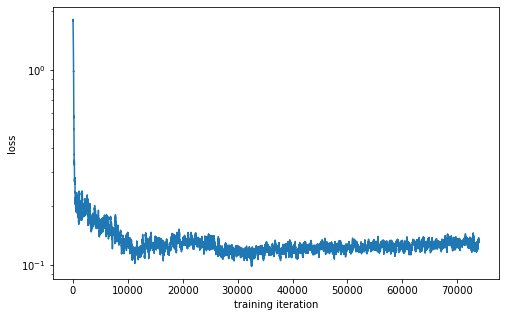

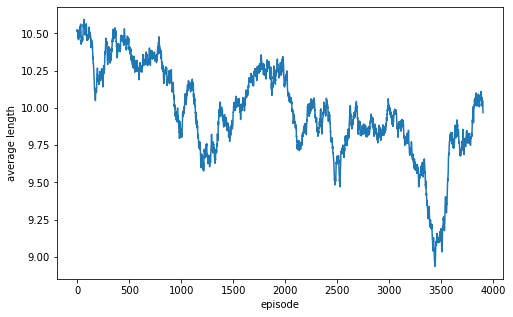

In [16]:
def _moving_avg(x, N=20):
    return np.convolve(np.array(x), np.ones((N,))/N, mode='valid')

plt.figure(figsize=(8,5))
plt.semilogy(_moving_avg(losses, 100))
plt.ylabel('loss')
plt.xlabel('training iteration')

plt.figure(figsize=(8,5))
plt.plot(_moving_avg(path_lengths, 100))
plt.ylabel('average length')
plt.xlabel('episode')

## solution test Best Model

Text(0.5, 1.0, 'model / len = 3.1283154413104057')

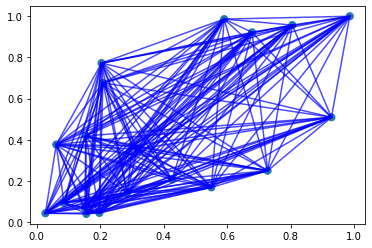

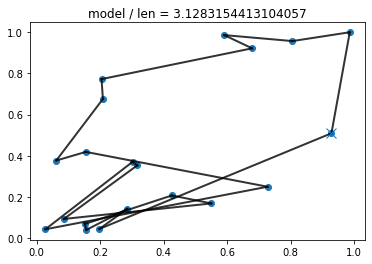

In [20]:

Q_func, Q_net, optimizer, lr_scheduler = init_model(os.path.join(FOLDER_NAME, 'ep_3518_length_8.909497960703447.pt'))

""" A function to plot solutions
"""
def plot_solution(coords, mat, solution):
    plt.scatter(coords[:,0], coords[:,1])
    n = len(coords)
    
    for idx in range(n-1):
        i, next_i = solution[idx], solution[idx+1]
        plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    
    i, next_i = solution[-1], solution[0]
    plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    plt.plot(coords[solution[0], 0], coords[solution[0], 1], 'x', markersize=10)


    
""" Generate example solutions
"""
NR_NODES = 20
# for sample in range(10):
coords, W_np = get_graph_mat(n=NR_NODES)
plot_graph(coords, W_np)
W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)

solution = [random.randint(0, NR_NODES-1)]
current_state = State(partial_solution=solution, W=W, coords=coords)
current_state_tsr = state2tens(current_state)

while not is_state_final(current_state):
    next_node, est_reward = Q_func.get_best_action(current_state_tsr, 
                                                   current_state)


    solution = solution + [next_node]
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)

plt.figure()
plot_solution(coords, W, solution)
plt.title('model / len = {}'.format(total_distance(solution, W)))
